<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [413]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator

In [414]:
ticker = "RKLB"
look_back = 5 #  number of past days we want to use to predict 1 day in the future.
max_data_size = 730 # ~2 years
split_percent = 0.90 # use 90% of the data  for train
print_level = 'DEBUG'
model_file_path = '/content/drive/MyDrive/models/'+ticker+'_06.h5'
nr_of_features = 2
np.random.seed(42)

In [415]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T'
print(url)
stock_api_response = pd.read_json(url)
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);

data = []
lstm_data = []
split_coefficient = 1

for key, value in stock_api_data.items():
  date = key
  open = float(value.get('1. open'))
  high = float(value.get('2. high'))
  low = float(value.get('3. low'))
  close = float(value.get('4. close'))
  adjusted_close = float(value.get('5. adjusted close'))
  volume = int(value.get('6. volume'))
  divident = float(value.get('7. dividend amount'))

  if float(value.get('8. split coefficient')) > 1:
    split_coefficient = float(value.get('8. split coefficient'))
    
  open = open / split_coefficient
  high = high /split_coefficient
  close = close / split_coefficient
  low = low / split_coefficient
  
  # 3 features
  lstm_data.append([
    close#,
    #high,
    #low
  ])

  data.append([
      date,
      close,
      volume,
      high,
      low,
      open,
      divident
      ])

last_date =  str(data[0][0])

if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
  lstm_data = np.flip(lstm_data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
  lstm_data = np.flip(lstm_data,axis=0)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=RKLB&outputsize=full&apikey=3F4URDEKOPLFH25T


In [416]:
# Normalised values [0,max_price] as integer
values = data[:,2].astype(int)
max_price = np.amax(lstm_data)

values_scaled = (max_price*(values - np.min(values))/np.ptp(values)).astype(int)
lstm_data = np.append(lstm_data, np.expand_dims(values_scaled, axis=1), axis=1)

if print_level == 'DEBUG':
  print('max_price:',max_price)
  print('values:',values[:5])
  print('values_scaled',values_scaled[:5])
  print('lstm_data:',lstm_data[:5])

max_price: 20.72
values: [1279000 5599989 3293796 2825007 2264954]
values_scaled [0 2 0 0 0]
lstm_data: [[ 11.57  0.00]
 [ 10.43  2.00]
 [ 9.96  0.00]
 [ 10.35  0.00]
 [ 10.03  0.00]]


In [417]:
if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('data ===>', 'size:',len(data), 'max_data_size:', max_data_size, 'shape:', data.shape)
  print(data[:look_back])
  print('lstm_data ===>', 'size:',len(lstm_data), 'max_data_size:', max_data_size, 'shape:', lstm_data.shape)
  print(lstm_data[:look_back])

data ===> size: 48 max_data_size: 730 shape: (48, 7)
[['2021-08-24' '11.57' '1279000' '11.9' '11.11' '11.3' '0.0']
 ['2021-08-25' '10.43' '5599989' '11.6' '9.98' '11.5805' '0.0']
 ['2021-08-26' '9.96' '3293796' '11.04' '9.96' '11.0' '0.0']
 ['2021-08-27' '10.35' '2825007' '10.5' '9.5' '10.3141' '0.0']
 ['2021-08-30' '10.03' '2264954' '10.51' '9.8' '10.5' '0.0']]
lstm_data ===> size: 48 max_data_size: 730 shape: (48, 2)
[[ 11.57  0.00]
 [ 10.43  2.00]
 [ 9.96  0.00]
 [ 10.35  0.00]
 [ 10.03  0.00]]


In [418]:
df = pd.DataFrame(data,columns=['Date','Close','Volume','High','Low','Open','Divident'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
#df.head()

df_train = df.iloc[:split]
df_test = df.iloc[split:]

lstm_train_data = lstm_data[:split]
lstm_test_data = lstm_data[split:]

In [419]:
if print_level == 'DEBUG':
  print('df_test ===>', 'size:',len(df_test),'shape:', df_test.shape)
  print(df_test.head())

  print('df_train ===>', 'size:',len(df_train),'shape:', df_train.shape)
  print(df_train.head())

  print('lstm_test_data ===>', 'size:',len(lstm_test_data), 'shape:', lstm_test_data.shape)
  print(lstm_test_data[:2*(look_back + 1)])

  print('lstm_train_data ===>', 'size:',len(lstm_train_data), 'shape:', lstm_train_data.shape)
  print(lstm_train_data[:2*(look_back + 1)])

df_test ===> size: 5 shape: (5, 10)
          Date  Close   Volume     High  ... Divident 50MA 100MA  200MA
43  2021-10-25  12.99  1929249    13.13  ...      0.0  NaN   NaN    NaN
44  2021-10-26  13.22  2831936  13.8164  ...      0.0  NaN   NaN    NaN
45  2021-10-27  12.84  1351879    13.22  ...      0.0  NaN   NaN    NaN
46  2021-10-28  13.37  2080847    13.55  ...      0.0  NaN   NaN    NaN
47  2021-10-29  14.05  1987228    14.14  ...      0.0  NaN   NaN    NaN

[5 rows x 10 columns]
df_train ===> size: 43 shape: (43, 10)
         Date  Close   Volume   High  ... Divident 50MA 100MA  200MA
0  2021-08-24  11.57  1279000   11.9  ...      0.0  NaN   NaN    NaN
1  2021-08-25  10.43  5599989   11.6  ...      0.0  NaN   NaN    NaN
2  2021-08-26   9.96  3293796  11.04  ...      0.0  NaN   NaN    NaN
3  2021-08-27  10.35  2825007   10.5  ...      0.0  NaN   NaN    NaN
4  2021-08-30  10.03  2264954  10.51  ...      0.0  NaN   NaN    NaN

[5 rows x 10 columns]
lstm_test_data ===> size: 5 shape

In [429]:
np.set_printoptions(formatter={'float': '{: 0.12f}'.format})

mean_data = np.mean(lstm_data)
max_data = np.amax(lstm_data)

#print('mean:', mean_data, 'max:', max_data, 'min:',0)
scaler_data = [[mean_data], [max_data*1.5], [0]]

scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = scaler.fit(lstm_data)
scaler = scaler.fit(scaler_data)

lstm_train_data_scaled = scaler.transform(lstm_train_data)
if print_level == 'DEBUG':
  print(lstm_train_data_scaled[:look_back+1])
  print(lstm_train_data_scaled.shape)

lstm_test_data_scaled = scaler.transform(lstm_test_data)
if print_level == 'DEBUG':
  print(lstm_test_data_scaled[:look_back+1])
  print(lstm_test_data_scaled.shape)

[[ 0.372265122265  0.000000000000]
 [ 0.335585585586  0.064350064350]
 [ 0.320463320463  0.000000000000]
 [ 0.333011583012  0.000000000000]
 [ 0.322715572716  0.000000000000]
 [ 0.322715572716  0.000000000000]]
(43, 2)
[[ 0.417953667954  0.000000000000]
 [ 0.425353925354  0.000000000000]
 [ 0.413127413127  0.000000000000]
 [ 0.430180180180  0.000000000000]
 [ 0.452059202059  0.000000000000]]
(5, 2)


In [421]:
train_generator = TimeseriesGenerator(lstm_train_data_scaled, lstm_train_data_scaled, length=look_back, batch_size=1)

if print_level == 'TRACE':
  print('Samples: %d' % len(train_generator))
  # print each sample
  for i in range(2):
    x, y = train_generator[i]
    print('%s => %s' % (x, y))

In [ ]:
model = None
try:
  model = keras.models.load_model(model_file_path)
  modified = os.path.getmtime(model_file_path)

  print(data[0][0] - datetime.fromtimestamp(modified).date() )
  print('Loaded', ticker , 'model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
except:
  model = None
  print('Model ' + ticker + ' does not exists.')

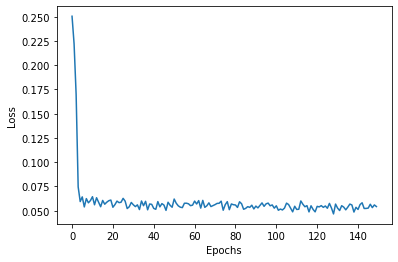

In [422]:
if model is None:
  model = Sequential()
  model.add(LSTM(units=50, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, activation="tanh"))
  model.add(Dropout(0.2))
  model.add(Dense(nr_of_features))

  model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=0.0001),
      metrics=["mae"]
  )
    
  #model.summary()
  print('Model ' + ticker + ' compiled.')
  
  modelo = model.fit(train_generator, epochs=150, verbose=0)
  
  model.save(model_file_path)
  print('Saved model ' + ticker)

  if print_level == 'DEBUG':
    plt.plot(modelo.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [428]:
test_generator = TimeseriesGenerator(lstm_test_data_scaled, lstm_test_data_scaled, length=look_back, batch_size=1)

print('Samples: %d' % len(test_generator))
# print each sample
if print_level == 'TRACE':
  for i in range(2):
    x, y = test_generator[i]
    print('%s => %s' % (x, y))

ValueError: ignored

In [425]:
#Make prediction
prediction_scaled = model.predict(test_generator)

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.12f}'.format})
  print(prediction_scaled[:5])

prediction = scaler.inverse_transform(prediction_scaled)
pred_prices = prediction[:,0]

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('prediction shape:',prediction.shape)

  for x in range(look_back + 1):
    print('pred:',prediction[x], 'test:', lstm_test_data[x])


[[ 0.330848097801  0.023268170655]]
prediction shape: (1, 2)
pred: [ 10.28  0.72] test: [ 12.99  0.00]


IndexError: ignored

In [426]:
def predict(num_prediction, model):
    prediction_list = lstm_test_data_scaled[-look_back:]
    #print(prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date,num_prediction):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

num_prediction = look_back * 2
forecast_scaled = predict(num_prediction, model)
#print(forecast_scaled)
forecast_dates = predict_dates(df['Date'].values[-1],num_prediction)

forecast = scaler.inverse_transform(forecast_scaled.reshape((-1,1)))
forecast_prices = forecast[0::nr_of_features].reshape((-1))
#forecast_dates,forecast
forecast_prices

array([ 14.05,  13.49,  13.51,  13.53,  13.61,  13.65,  13.63,  13.64,
        13.65,  13.65,  13.66])

In [427]:
trace1 = go.Candlestick(
    x = df_train['Date'],
    open = df_train['Open'],
    high = df_train['High'],
    low = df_train['Low'],
    close = df_train['Close'],
    name = 'Train'
)

trace2 = go.Candlestick(
    x = df_test['Date'],
    open = df_test['Open'],
    high = df_test['High'],
    low = df_test['Low'],
    close = df_test['Close'],
    increasing={'line': {'color': 'lightblue'}},
    decreasing={'line': {'color': 'purple'}},    
    name ='Test'
)

trace3 = go.Scatter(
    x = df_test['Date'],
    y = pred_prices,
    name ='Test'
)

trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast_prices,
    name ='Forecast'
)

trace5 = go.Scatter(
    x = df['Date'],
    y = df['50MA'],
    mode='lines',
    name ='50MA'
)

trace6 = go.Scatter(
    x = df['Date'],
    y = df['100MA'],
    mode='lines',
    name ='100MA'
)

trace7 = go.Scatter(
    x = df['Date'],
    y = df['200MA'],
    mode='lines',
    name ='200MA'
)

#'Date','Close','Volume','High','Low','Open','Divident'
open_price =  str(data[-1][5])
low_price =  str(data[-1][3])
high_price =  str(data[-1][4])
close_price =  str(data[-1][1])

layout = go.Layout(
    title = ticker + ' Date:' + last_date + ' Open:' + open_price + ' High:' + high_price + ' Low:' + low_price + ' Close:' + close_price,
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7], layout=layout)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False)
config = dict({'scrollZoom': True})
fig.show(config=config)

fig.write_html('/content/drive/MyDrive/models/charts/'+ticker+ '_06_' + last_date + '_forecast.html')

fig1 = px.bar(
    x=df['Date'], 
    y=df['Volume'], 
    height=250, 
    labels={"x": "Dates","y": "Volume"},
    title=ticker)
fig1.show()